[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1n3uLs7P5wg0yLsgaa0ipfudQ_QwknT5v?usp=sharing)

# About the tutorial
Datasets are essential in both supervised and unsupervised machine learning settings. In a typical reinforcement learning (RL) setting, the agent must interact with the environment in order to collect data for learning. Thus, environments serve a kind of similar function in RL as datasets do in supervised and unsupervised learning. In this tutorial, we will explain how to use RLHive environments. Note that this tutorial is on single-agent environments.

# Introduction and Setup

### What is RLHive and how to install it

RLHive is a framework designed to facilitate research in RL. It provides the components necessary to run a full RL experiment, for both single agent and multi agent environments. It is designed to be readable and easily extensible, to allow users to quickly run and experiment with their own ideas. For installation, you can check [this notebook](https://colab.research.google.com/drive/11YirxgoVD7gjN02TdAeyFXOL1qH7Eydv?usp=sharing).

In [ ]:
!pip install ruamel.yaml
!pip install pyglet
!pip install git+https://github.com/chandar-lab/RLHive.git@dev

!python -m pip install pyvirtualdisplay
!pip3 install box2d
!sudo apt-get install xvfb

In [ ]:
import torch
import hive
from hive.utils.registry import registry
from hive.envs.base import BaseEnv
from hive.envs.gym_env import GymEnv
from hive.envs.env_spec import EnvSpec
from ruamel import yaml
import sys
import os
import os.path
import numpy as np
import matplotlib.pyplot as plt
from pyvirtualdisplay import Display
%matplotlib inline

### How to install environments

RLHive currently supports the following environments:



*   Gym classic control
*   Atari
* Minatar (simplified Atari)
* Minigrid (single-agent grid world)
* Marlgrid (multi-agent)
* Pettingzoo (multi-agent)

To install Gym, you could simply run `pip install gym==0.21.0`. You can also install dependencies necessary for the environments that RLHive comes with by running `pip install rlhive[<env_names>]` where `<env_names>` is a comma separated list made up of `atari`, `gym_minigrid`, and `pettingzoo`.

Minatar and Marlgrid are also supported, but must be installed separately.

* To install Minatar, run `pip install MinAtar@git+https://github.com/kenjyoung/MinAtar.git@8b39a18a60248ede15ce70142b557f3897c4e1eb`
* To install Marlgrid, run `pip install marlgrid@https://github.com/kandouss/marlgrid/archive/refs/heads/master.zip`

In [ ]:
!pip install rlhive[gym_minigrid]
!pip install gym==0.21.0

In [ ]:
import gym
import gym_minigrid
from gym_minigrid.wrappers import ReseedWrapper
from gym.spaces.discrete import Discrete

# Creating environments

Every environment used in RLHive should be a subclass of `hive.envs.base.BaseEnv`. It should provide a `reset` function that resets the environment to a new episode and returns a tuple of `(observation, turn)` and a `step` function that takes in an action, performs the step in the environment, and returns a tuple of `(observation, reward, done, turn, info)`. All these values correspond to their canonical meanings, and `turn` corresponds to the index of the agent whose turn it is (in multi-agent environments).

The `reward` return value can be a single number, an array, or a dictionary. If it’s a number, then that same reward will be given to every single agent. If it’s an array, the agents get the reward corresponding to their index in the runner. If it’s a dictionary, the keys should be the agent ids, and the value the reward for that agent.


### `GymEnv`

The [OpenAI gym](https://www.gymlibrary.dev/), which provides a flexible manner of designing environments, initializing them, and interacting with them, has become well-known between RL researchers.

If your environment is a gym environment, and you do not need to preprocess the observations generated by the environment, then you can directly use the `hive.envs.gym_env.GymEnv`.

In [ ]:
env = GymEnv("CartPole-v0")

/usr/local/lib/python3.7/dist-packages/gym/envs/registration.py:594: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  def reset(self, **kwargs):
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.


### `EnvSpec`

Each environment should also provide an `EnvSpec` environment that indicates what space is for the observations, action. These should be lists with one element for each agent. The agent uses this information to create its network according to provided format of valid actions and observations.

In [ ]:
env_spec = env.env_spec
obs_spec, act_spec = env_spec.observation_space[0], env_spec.action_space[0]
print("Environment name : \n", env_spec.env_name)
print("Environment observation space: \n", obs_spec)
print("Environment action space: \n", act_spec)
print("Environment info: \n", env_spec.env_info)

Environment name : 
 CartPole-v0
Environment observation space: 
 Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Environment action space: 
 Discrete(2)
Environment info: 
 {}


### Environment basic methods

To work with any environment, we first set `seed` (to ensure that the code is reproducible), `reset` the environment to a new initial state, and then use `step` to perform the specified action and return updated information collected from the environment. Moreover, since for image-based environments rendering is important, you can use use `render` function.Finally, when we're done with the environment, we can `close` it.

In [ ]:
env.seed(42)
obs, turn = env.reset()
print("Environment initial observation : \n", obs)
print("Environment initial turn: \n", turn)

Environment initial observation : 
 [ 0.0273956  -0.00611216  0.03585979  0.0197368 ]
Environment initial turn: 
 0


/usr/local/lib/python3.7/dist-packages/gym/utils/passive_env_checker.py:175: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
/usr/local/lib/python3.7/dist-packages/gym/utils/passive_env_checker.py:191: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
/usr/local/lib/python3.7/dist-packages/gym/utils/passive_env_checker.py:196: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.


The `turn` indicats the agent ID, which is 0 in the case of a single agent setting.

In [ ]:
# This cell is just to show the animation in the notebook

display = Display(visible=0, size=(1400, 900))
display.start()

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

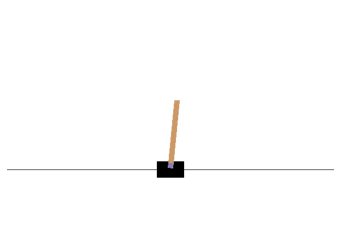

In [ ]:
num_steps = 100
img = plt.imshow(env.render())

for t in range(num_steps):
    obs, reward, done, turn, info = env.step(act_spec.sample()) # Random policy
    img.set_data(env.render()) 
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    if done:
        obs, turn = env.reset()

env.close()

### Custom environment

You can also create your own custom environment using `GymEnv`. If you need to add extra preprocessing or change the default way that environment/`EnvSpec` creation is done, you can simply subclass this class and override either `create_env()` and/or `create_env_spec()`.


In [ ]:
class MiniGridEnv(GymEnv):
    def __init__(self, env_name, num_players=1, seed=42, **kwargs):
        super().__init__(env_name, num_players, seed=seed, **kwargs)

    def create_env(self, env_name, seed, **kwargs):
        self._env = gym.make(env_name, **kwargs)
        self._env = ReseedWrapper(self._env, seeds=[seed])

    def create_env_spec(self, env_name, **kwargs):
        env_spec = super().create_env_spec(env_name, **kwargs)
        return env_spec

    def step(self, action):
        return super().step(action)

We can also create an environment from scratch inherting `hive.envs.base.BaseEnv`. For instance, in the following cell we have `GridEnv`; it is a 1$\times$7 grid, indexed from -3 to 3 from left to right. The agent always starts in cell number 0, and at each step, it can choose to walk right (if possible), left (if possible), or stay in the current cell. The agent would be rewarded only when it is in cell 1.

In [ ]:
class GridEnv(BaseEnv):
    def __init__(self, env_name = 'GridEnv', max_steps = 20, **kwargs):
        self._num_grid = 7
        self._observation = 0
        self._num_steps = 0
        self._max_steps = max_steps

        super().__init__(self.create_env_spec(env_name, **kwargs), 1)

    def create_env_spec(self, env_name, **kwargs):
        observation_spaces = [Discrete(self._num_grid, start = self._num_grid // 2)]
        action_spaces = [Discrete(3, start = -1)]
        return EnvSpec(
            env_name=env_name,
            observation_space=observation_spaces,
            action_space=action_spaces,
        )

    def reset(self):
        self._observation = self._num_steps = 0
        return self._observation, self._turn

    def step(self, action):
        self._num_steps += 1

        if action == 1:
            self._observation = min(self._num_grid // 2, self._observation+1)
        elif action == -1:
            self._observation = max(-self._num_grid // 2, self._observation-1)
        
        if self._observation == 1:
            reward = 1
        else:
            reward = 0

        done = self._num_steps == self._max_steps
        info = {}

        return self._observation, reward, done, self._turn, info

    def render(self):
        pass
    def close(self):
        pass
    def save(self):
        pass
    def seed(self):
        pass
    

In [ ]:
env = GridEnv()
env_spec = env.env_spec
obs_spec, act_spec = env_spec.observation_space[0], env_spec.action_space[0]
print("Environment name : \n", env_spec.env_name)
print("Environment observation space: \n", obs_spec)
print("Environment action space: \n", act_spec)
print("Environment info: \n", env_spec.env_info)

Environment name : 
 GridEnv
Environment observation space: 
 Discrete(7, start=3)
Environment action space: 
 Discrete(3, start=-1)
Environment info: 
 {}


In [ ]:
done = False
env.reset()

while not done:
    obs, reward, done, turn, info = env.step(act_spec.sample())
    print("Cell {}, Reward {}".format(obs, reward))

env.close()

Cell 1, Reward 1
Cell 1, Reward 1
Cell 1, Reward 1
Cell 1, Reward 1
Cell 1, Reward 1
Cell 2, Reward 0
Cell 2, Reward 0
Cell 3, Reward 0
Cell 3, Reward 0
Cell 2, Reward 0
Cell 3, Reward 0
Cell 2, Reward 0
Cell 2, Reward 0
Cell 3, Reward 0
Cell 3, Reward 0
Cell 2, Reward 0
Cell 1, Reward 1
Cell 2, Reward 0
Cell 3, Reward 0
Cell 2, Reward 0


#### Registering environments
The registry module `hive.utils.registry` is used to register classes in the RLHive Registry. Consider registering `GridEnv` we created before:

In [ ]:
registry.register(name = 'GridEnv', constructor = GridEnv, type = GridEnv)

Also, when you're using the gym-based environments (e.g. `MiniGridEnv`), you can simply use `gym.register`:



In [ ]:
gym.register(id = 'MyMiniGrid', entry_point = MiniGridEnv)

More than one environment can be registered at once using the `register_all` method. Consider registering two environments `Env1` and `Env2` (inheriting `BaseEnv`):

In [ ]:
class Env1(BaseEnv):
    def __init__(self, env_name = 'Env1', **kwargs):
        pass
    def reset(self):
        pass
    def step(self):
        pass
    def render(self):
        pass
    def close(self):
        pass
    def save(self):
        pass

class Env2(BaseEnv):
    def __init__(self, env_name = 'Env2', **kwargs):
        pass
    def reset(self):
        pass
    def step(self):
        pass
    def render(self):
        pass
    def close(self):
        pass
    def save(self):
        pass

In [ ]:
registry.register_all(
    BaseEnv,
    {
        "Env1": Env2,
        "Env1": Env2,
    },
)